In [ ]:
%pip install transformers tokenizers torch
from sklearn import datasets
%store -r index
%store -r beginning_index
%store -r ending_index

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt


c:\Users\sm3532\Desktop\projectl\v\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#load model
model_name = "gpt2" 
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.eval()  # turn off dropout
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [6]:
def surprisal_and_token(sentence):
    # add bos token to sentence
    sentence = tokenizer.bos_token + sentence + tokenizer.eos_token
    inputs = tokenizer(sentence, return_tensors="pt", add_special_tokens=False, return_offsets_mapping=True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.log_softmax(logits, dim = -1)
    input_ids = inputs["input_ids"][0].to(device)
    offsets = inputs['offset_mapping'][0].tolist()
    # get tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    surprisals = []
    for id in range(1, len(input_ids)):
        token_id = int(input_ids[id])
        log_prob = probs[0, id-1, token_id].item()
        surprisal = -log_prob / math.log(2)
        surprisals.append((tokens[id], offsets[id], surprisal))
    return surprisals

def sentence_surprisal(sentence):
    surprisals = surprisal_and_token(sentence)
    total = 0
    for surprisal in surprisals:
        total +=surprisal[2]
    return total

def average_sentence_surprisal(sentences):
    sum = 0
    for sentence in sentences:
        sum += sentence_surprisal(sentence)
    return sum / len(sentences)

In [ ]:
# Open and read the file
with open('e.txt', 'r') as file:
    sentences = file.readlines()

range = sentences[beginning_index:ending_index]

# If you want to append to an existing list
sentences_list = []
for sentence in range:
    sentences_list.append(sentence.strip())  # Remove any trailing newlines

print(f"Average sentence surprisals for GPT2 English: {average_sentence_surprisal(sentences_list)}")

Average sentence surprisals for GPT2 English: 37.817523981839706


Tokens and Offsets:
Token 0: 'It' -> 'It' (start: 0, end: 2)
Token 1: 'Ġis' -> ' is' (start: 2, end: 5)
Token 2: 'Ġunfortunately' -> ' unfortunately' (start: 5, end: 19)
Token 3: 'Ġtrue' -> ' true' (start: 19, end: 24)
Token 4: '.' -> '.' (start: 24, end: 25)
Tokens, Offsets, Surface Forms, and Surprisal Values:
It: 'It' (0-2) -> Surprisal: 14.1719
Ġis: ' is' (2-5) -> Surprisal: 4.1837
Ġunfortunately: ' unfortunately' (5-19) -> Surprisal: 11.3864
Ġtrue: ' true' (19-24) -> Surprisal: 4.5666
.: '.' (24-25) -> Surprisal: 6.3368

Final Word-Level Surprisal Values:
Word: It -> Surprisal: 14.1719
Word:  is -> Surprisal: 4.1837
Word:  unfortunately -> Surprisal: 11.3864
Word:  true -> Surprisal: 4.5666
Word: . -> Surprisal: 6.3368


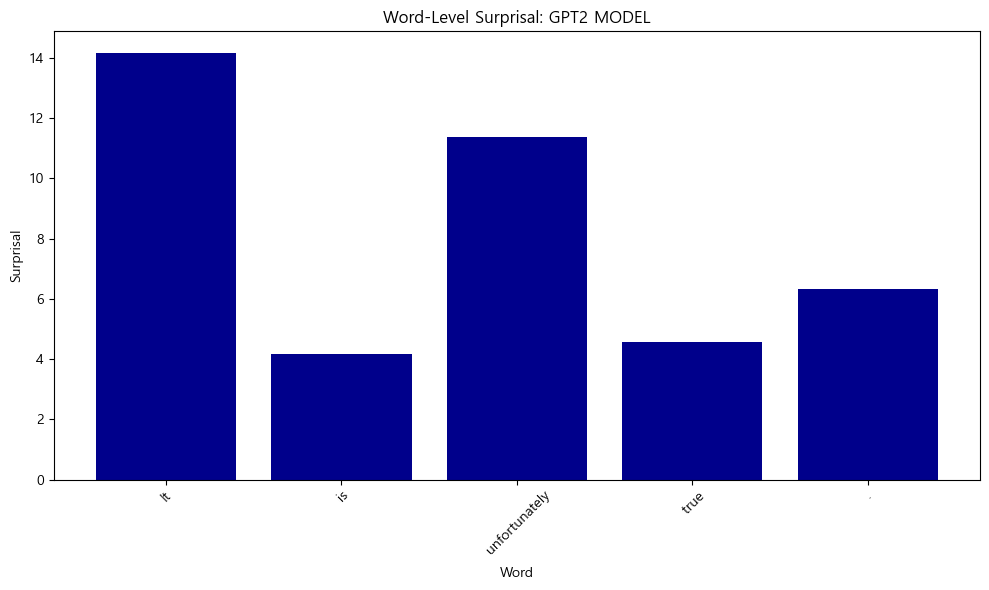

In [ ]:
wwords = []  # List to store word-level tokens
ssurp = [] 

plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False  
def group_surprisal_by_char_spans(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", return_offsets_mapping=True, add_special_tokens=True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        log_probs = F.log_softmax(logits, dim=-1)

    input_ids = inputs["input_ids"][0]
    offsets = inputs["offset_mapping"][0].tolist()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    print("Tokens and Offsets:")
    for i, (token_id, (start, end)) in enumerate(zip(input_ids, offsets)):
        token = tokens[i]
        token_str = sentence[start:end] if start != end else "" 
        print(f"Token {i}: '{token}' -> '{token_str}' (start: {start}, end: {end})")

    #  process tokens and compute surprisal
    print("Tokens, Offsets, Surface Forms, and Surprisal Values:")
    for i, (token_id, (start, end)) in enumerate(zip(input_ids, offsets)):
        token = tokens[i]
        token_str = sentence[start:end] if start != end else ""  # Get the surface form of the token
        
        # for the first token
        if i == 0 or i == len(input_ids) - 2 or i == len(input_ids) -1:
            wwords.append(token_str)
            log_prob = log_probs[0, i - 1, token_id].item()  # Log prob for first token (no previous token)
            surprisal = -log_prob / math.log(2)
            ssurp.append(surprisal)
            print(f"{token}: '{token_str}' ({start}-{end}) -> Surprisal: {surprisal:.4f}")
            continue

        # for tokens starting with 'Ġ' (start of a new word)
        if token.startswith('Ġ'):
            # this is the start of a new word, append it separately
            wwords.append(token_str)  # append only the new word
            log_prob = log_probs[0, i - 1, token_id].item()  # log prob for this word for surp
            surprisal = -log_prob / math.log(2)
            ssurp.append(surprisal)
            print(f"{token}: '{token_str}' ({start}-{end}) -> Surprisal: {surprisal:.4f}")
        else:
            if len(wwords) > 0:
                # Append the current token to the last word
                wwords[-1] += token_str
                log_prob = log_probs[0, i - 1, token_id].item()
                surprisal = -log_prob / math.log(2)
                ssurp[-1] += surprisal  # Update the surprisal for this word
                print(f"{token}: '{wwords[-1]}' ({start}-{end}) -> Surprisal: {surprisal:.4f}")

    # final word-surprisal pairings for verification
    print("\nFinal Word-Level Surprisal Values:")
    for word, surprisal in zip(wwords, ssurp):
        print(f"Word: {word} -> Surprisal: {surprisal:.4f}")
    word_surp = [("<BOS>", float('nan'))]

    current_word = ""
    current_surprisal = 0.0
    prev_end = 0

    return word_surp
sentence = sentences[index]
# Run the function
result = group_surprisal_by_char_spans(sentence)
if len(wwords) == len(ssurp):
    plt.figure(figsize=(10, 6))
    plt.bar(wwords, ssurp, color='darkblue')
    plt.xlabel('Word')
    plt.ylabel('Surprisal')
    plt.title('Word-Level Surprisal: GPT2 MODEL')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot plot: Mismatched lengths between words and surprisal values.")